In [1]:
%run 0_result_analysis_functions.ipynb

In [2]:
# Import catalog with SimstackWrapper
# 2-sf/qt
combined_pickle_filename = "cosmos2020_farmer_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5_6_8_10p0_X_4_foregnd_atonce_bootstrap_1-100"
prefix='SF_QT__COSMOS2020_'

combined_pickle_path = os.environ['PICKLESPATH']+'/'+os.path.join("simstack","stacked_flux_densities", "spire", combined_pickle_filename)
underscore_suffix = "" # "__"
path_ini_file = os.path.join(combined_pickle_path+underscore_suffix, "cosmos2020_farmer2.ini")
path_pickle_file = os.path.join(combined_pickle_path+underscore_suffix, combined_pickle_filename+".pkl")
if os.path.isfile(path_ini_file):
    simstack_catalog_object = SimstackWrapper(path_ini_file, read_maps=False, read_catalog=True, keep_catalog=True, stack_automatically=False, save_automatically=False)
else:
    print(path_ini_file+' not found')

In [3]:
simstack_maps_object = SimstackWrapper(path_ini_file, save_automatically=False, read_maps=True, read_catalog=False)

In [4]:
# Import saved stacking results
simstack_object = SimstackToolbox.import_saved_pickles(path_pickle_file)

In [5]:
# Pass saved results into SimstackResults
simstack_object = SimstackResults(simstack_object)

In [6]:
# Pass saved results into SimstackPlots
simstack_object = SimstackPlots(simstack_object)

In [7]:
simstack_object.config_dict['catalog']['classification'].keys()

dict_keys(['redshift', 'stellar_mass', 'split_params'])

In [8]:
fluxes_dict = parse_fluxes(simstack_object)

In [9]:
np.shape(fluxes_dict['flux'])

(7, 12, 4, 2)

In [10]:
# SLOW!
sed_dict = get_fast_sed_dict(simstack_object, fluxes_dict, simstack_catalog_object)

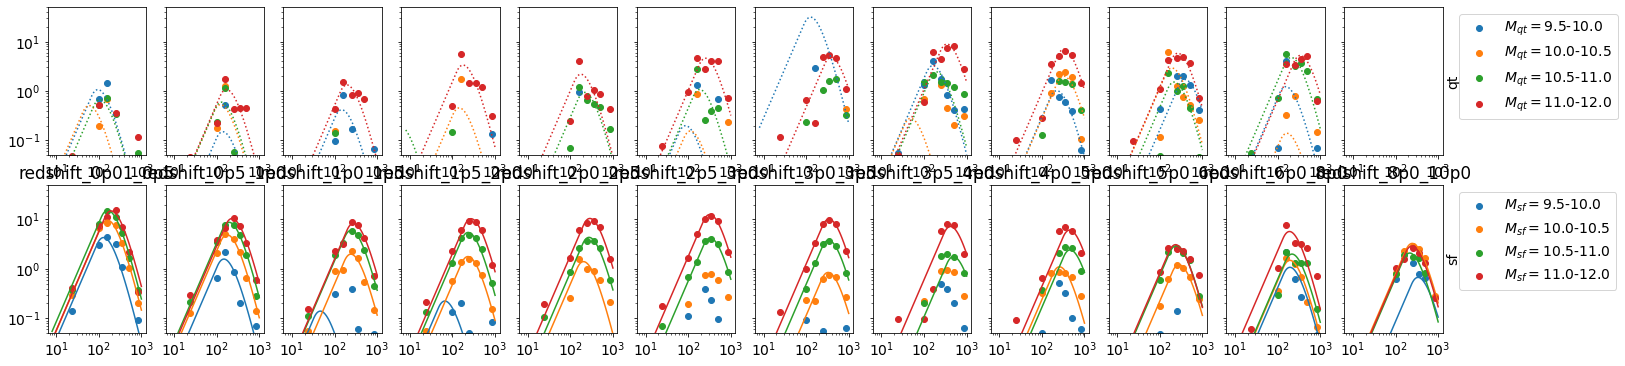

In [11]:
plot_pops(simstack_object,sed_dict=sed_dict)

# Fit model to stacked Fluxes

In [12]:
As_sf = np.array([sed_dict['sed_params'][i]['A'].value for i in sed_dict['sed_params'] if 'params_0' not in i])
Ts_sf = np.array([(1+sed_dict['redshift'][i])*sed_dict['sed_params'][i]['T_observed'].value for i in sed_dict['sed_params'] if 'params_0' not in i])

Ms_sf = np.array([sed_dict['stellar_mass'][i] for i in sed_dict['stellar_mass'] if 'params_0' not in i])
Zs_sf = np.array([sed_dict['redshift'][i] for i in sed_dict['redshift'] if 'params_0' not in i])

In [13]:
As_qt = np.array([sed_dict['sed_params'][i]['A'].value for i in sed_dict['sed_params'] if 'params_1' not in i])
Ts_qt = np.array([(1+sed_dict['redshift'][i])*sed_dict['sed_params'][i]['T_observed'].value for i in sed_dict['sed_params'] if 'params_1' not in i])

Ms_qt = np.array([sed_dict['stellar_mass'][i] for i in sed_dict['stellar_mass'] if 'params_1' not in i])
Zs_qt = np.array([sed_dict['redshift'][i] for i in sed_dict['redshift'] if 'params_1' not in i])

In [14]:
idx_keep_sf = (Zs_sf > 0.05) & (As_sf > -35.5) & (Ts_sf < 65)
cube_sf = np.array([Zs_sf[idx_keep_sf],Ms_sf[idx_keep_sf]])
idx_keep_qt = (Zs_sf > 0.05) & (As_qt > -35.5) & (Ts_qt < 65)
cube_qt = np.array([Zs_qt[idx_keep_qt],Ms_qt[idx_keep_qt]])

In [15]:
# Define Fit Parameters
fit_params_Adust = Parameters()
fit_params_Adust.add('offset', value=1e-3 * np.random.randn())
fit_params_Tdust = Parameters()
fit_params_Tdust.add('offset', value=1e-3 * np.random.randn())

catalog_keys = []
for key, val in simstack_object.config_dict['catalog']['classification'].items():
    if 'redshift' in key:
        value = 1.4
    else:
        value=1e-3 * np.random.randn()
        
    if 'split_params' not in key:
        fit_params_Adust.add('slope_'+key, value=value)
        fit_params_Tdust.add('slope_'+key, value=value)
        catalog_keys.append(val['id'])
    
cov_Adust_sf = minimize(slope_A_Tdust, fit_params_Adust,
                     args=(cube_sf,),
                     kws={'y': As_sf[idx_keep_sf]},
                     nan_policy='propagate')
cov_Tdust_sf = minimize(slope_A_Tdust, fit_params_Tdust,
                     args=(cube_sf,),
                     kws={'y': Ts_sf[idx_keep_sf]},
                     nan_policy='propagate')

In [16]:
# Define Fit Parameters
fit_params_Adust = Parameters()
fit_params_Adust.add('offset', value=1e-3 * np.random.randn())
fit_params_Tdust = Parameters()
fit_params_Tdust.add('offset', value=1e-3 * np.random.randn())

catalog_keys = []
for key, val in simstack_object.config_dict['catalog']['classification'].items():
    if 'redshift' in key:
        value = 1.4
    else:
        value=1e-3 * np.random.randn()
        
    if 'split_params' not in key:
        fit_params_Adust.add('slope_'+key, value=value)
        fit_params_Tdust.add('slope_'+key, value=value)
        catalog_keys.append(val['id'])
    
cov_Adust_qt = minimize(slope_A_Tdust, fit_params_Adust,
                     args=(cube_qt,),
                     kws={'y': As_qt[idx_keep_qt]},
                     nan_policy='propagate')
cov_Tdust_qt = minimize(slope_A_Tdust, fit_params_Tdust,
                     args=(cube_qt,),
                     kws={'y': Ts_qt[idx_keep_qt]},
                     nan_policy='propagate')

In [17]:
catalog_keys_sfg = catalog_keys.copy()
catalog_keys_sfg.append('sfg')

In [18]:
idx_sfgs = simstack_catalog_object.catalog_dict['tables']['full_table']['sfg'] == 1
idx_qts = simstack_catalog_object.catalog_dict['tables']['full_table']['sfg'] == 0

In [19]:
model_cube_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs][catalog_keys]

Z_model_sf = model_cube_sf['lp_zBEST'].values
M_model_sf = model_cube_sf['lp_mass_med'].values
ra_model_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['ALPHA_J2000']
dec_model_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['DELTA_J2000']

In [20]:
model_cube_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts][catalog_keys]

Z_model_qt = model_cube_qt['lp_zBEST'].values
M_model_qt = model_cube_qt['lp_mass_med'].values
ra_model_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['ALPHA_J2000']
dec_model_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['DELTA_J2000']

In [21]:
model_cube = simstack_catalog_object.catalog_dict['tables']['full_table'][catalog_keys_sfg]

Z_model = model_cube['lp_zBEST'].values
M_model = model_cube['lp_mass_med'].values
ra_model = simstack_catalog_object.catalog_dict['tables']['full_table']['ALPHA_J2000']
dec_model = simstack_catalog_object.catalog_dict['tables']['full_table']['DELTA_J2000']

In [22]:
model_cube_sf = model_cube_sf.to_numpy().T
model_cube_qt = model_cube_qt.to_numpy().T
model_cube = model_cube.to_numpy().T

In [23]:
A_model_sf = model_A_Tdust(cov_Adust_sf.params, model_cube_sf)
T_model_sf = model_A_Tdust(cov_Tdust_sf.params, model_cube_sf)
#sed_model_params = {'A':cov_Adust.params, 'Tdust':cov_Tdust.params}

In [24]:
A_model_qt = model_A_Tdust(cov_Adust_qt.params, model_cube_qt)
T_model_qt = model_A_Tdust(cov_Tdust_qt.params, model_cube_qt)
#sed_model_params = {'A':cov_Adust.params, 'Tdust':cov_Tdust.params}

## Fit parameters directly to maps?

In [25]:
idx_sim_sf = ((A_model_sf > -36) & (A_model_sf < -32)) & (T_model_sf < 65) & (Z_model_sf > 0.05) 
idx_sim_qt = ((A_model_qt > -36) & (A_model_qt < -32)) & (T_model_qt < 65) & (Z_model_qt > 0.05) 

In [26]:
map_dict_sf = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key].copy()
    x, y = get_x_y_from_ra_dec(map_object, ra_model_sf[idx_sim_sf], dec_model_sf[idx_sim_sf])
    map_object['map_coords'] = [x,y]
    map_dict_sf[map_key]=map_object

In [27]:
map_dict_qt = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key].copy()
    x, y = get_x_y_from_ra_dec(map_object, ra_model_qt[idx_sim_qt], dec_model_qt[idx_sim_qt])
    map_object['map_coords'] = [x,y]
    map_dict_qt[map_key]=map_object

In [28]:
map_dict = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key].copy()
    map_object['map_coords']={}
    x_sf, y_sf = get_x_y_from_ra_dec(map_object, ra_model_sf, dec_model_sf)
    map_object['map_coords']['sf'] = [x_sf,y_sf]
    x_qt, y_qt = get_x_y_from_ra_dec(map_object, ra_model_qt, dec_model_qt)
    map_object['map_coords']['qt'] = [x_qt,y_qt]
    map_dict[map_key]=map_object

In [29]:
def direct_convolved_fit_A_Tdust_sf(params, X, y):

    v = params.valuesdict()#.copy()
    A_model = v.pop('A_offset')
    T_model = v.pop('T_offset')
    Z_model = X[0]
    i=0
    for ival in v:
        #print(ival)
        if 'A_' in ival:
            A_model+= X[i] * v[ival]
        else:
            T_model+= X[i] * v[ival]
            i+=1
    #pdb.set_trace()
    out_model = []
    for map_name in y:
        map_lambda = y[map_name]['wavelength']
        map_nu = c * 1.e6/map_lambda
        map_coords = y[map_name]['map_coords']
        hd = y[map_name]['header']
        map_sky = y[map_name]['map'] - np.mean(y[map_name]['map'])

        map_model = np.zeros_like(map_sky)
        map_pixels= np.zeros_like(map_sky)
        
        S_model = get_map_flux_mJy(np.array([map_nu]),A_model,T_model/(1+Z_model))

        map_model[map_coords[0],map_coords[1]]+=S_model
        map_pixels[map_coords[0],map_coords[1]]+=1
        
        fwhm = y[map_name]['fwhm']
        pix = y[map_name]['pixel_size']
        kern = gauss_kern(fwhm, np.floor(fwhm * 10) / pix, pix)
        tmap = smooth_psf(map_model, kern)
        tmap -= np.mean(tmap)
        
        #idx_fit = map_sky != 0
        #idx_fit = map_model != 0
        idx_fit = map_pixels != 0
        diff = map_sky - tmap
        out_model.extend(np.ravel(diff[idx_fit]))
            
        #pdb.set_trace()    
    return out_model

In [30]:
def direct_convolved_fit_A_Tdust_qt(params, X, y):

    v = params.valuesdict()#.copy()
    A_model = v.pop('A_offset')
    T_model = v.pop('T_offset')
    Z_model = X[0]
    i=0
    for ival in v:
        #print(ival)
        if 'A_' in ival:
            A_model+= X[i] * v[ival]
        else:
            T_model+= X[i] * v[ival]
            i+=1
    #pdb.set_trace()
    out_model = []
    for map_name in y:
        map_lambda = y[map_name]['wavelength']
        map_nu = c * 1.e6/map_lambda
        map_coords = y[map_name]['map_coords']
        hd = y[map_name]['header']
        map_sky = y[map_name]['map'] - np.mean(y[map_name]['map'])

        map_model = np.zeros_like(map_sky)
        map_pixels= np.zeros_like(map_sky)
        
        S_model = get_map_flux_mJy(np.array([map_nu]),A_model,T_model/(1+Z_model))

        map_model[map_coords[0],map_coords[1]]+=S_model
        map_pixels[map_coords[0],map_coords[1]]+=1
        
        fwhm = y[map_name]['fwhm']
        pix = y[map_name]['pixel_size']
        kern = gauss_kern(fwhm, np.floor(fwhm * 10) / pix, pix)
        tmap = smooth_psf(map_model, kern)
        tmap -= np.mean(tmap)
        
        #idx_fit = map_sky != 0
        #idx_fit = map_model != 0
        idx_fit = map_pixels != 0
        diff = map_sky - tmap
        out_model.extend(np.ravel(diff[idx_fit]))
            
        #pdb.set_trace()    
    return out_model

In [31]:
def direct_convolved_fit_A_Tdust(params, X, y):

    v = params.valuesdict()#.copy()
    A_model_sf = v.pop('A_offset_sf')
    T_model_sf = v.pop('T_offset_sf')
    A_model_qt = v.pop('A_offset_qt')
    T_model_qt = v.pop('T_offset_qt')
    idx_sf = X[-1] == 1
    idx_qt = X[-1] == 0
    Z_model_sf = X[0][idx_sf]
    Z_model_qt = X[0][idx_qt]
    
    i=0
    for ival in v:
        #print(ival)
        if 'A_' in ival:
            if 'sf' in ival:
                A_model_sf+= X[i][idx_sf] * v[ival]
            else:
                A_model_qt+= X[i][idx_qt] * v[ival]
        else:
            if 'sf' in ival:
                T_model_sf+= X[i][idx_sf] * v[ival]
            else:
                T_model_qt+= X[i][idx_qt] * v[ival]
                i+=1
                
    #pdb.set_trace()
    out_model = []
    for map_name in y:
        map_lambda = y[map_name]['wavelength']
        map_nu = c * 1.e6/map_lambda
        map_coords_sf = y[map_name]['map_coords']['sf']
        map_coords_qt = y[map_name]['map_coords']['qt']
        hd = y[map_name]['header']
        map_sky = y[map_name]['map'] - np.mean(y[map_name]['map'])

        map_model = np.zeros_like(map_sky)
        map_pixels= np.zeros_like(map_sky)
        
        S_model_sf = get_map_flux_mJy(np.array([map_nu]),A_model_sf,T_model_sf/(1+Z_model_sf))
        S_model_qt = get_map_flux_mJy(np.array([map_nu]),A_model_qt,T_model_qt/(1+Z_model_qt))
        
        #pdb.set_trace()
        map_model[map_coords_sf[0],map_coords_sf[1]]+=S_model_sf
        map_model[map_coords_qt[0],map_coords_qt[1]]+=S_model_qt
        map_pixels[map_coords_sf[0],map_coords_sf[1]]+=1
        map_pixels[map_coords_qt[0],map_coords_qt[1]]+=1
        
        fwhm = y[map_name]['fwhm']
        pix = y[map_name]['pixel_size']
        kern = gauss_kern(fwhm, np.floor(fwhm * 10) / pix, pix)
        tmap = smooth_psf(map_model, kern)
        tmap -= np.mean(tmap)

        idx_fit = map_pixels != 0
        diff = map_sky - tmap
        out_model.extend(np.ravel(diff[idx_fit]))
            
        #pdb.set_trace()    
    return out_model

# Fit just SF simultaneously

In [32]:
#These are the initial guesses
cov_Adust_sf.params

name,value,standard error,relative error,initial value,min,max,vary
offset,-48.4016947,1.42852576,(2.95%),-0.0016206941030551545,-inf,inf,True
slope_redshift,0.26931536,0.03877819,(14.40%),1.4,-inf,inf,True
slope_stellar_mass,1.26723126,0.13339153,(10.53%),0.0009021283468421687,-inf,inf,True


In [33]:
# Define Fit Parameters
fit_params_dsf = Parameters()
fit_params_dsf.add('A_offset', value=cov_Adust_sf.params['offset'].value)
fit_params_dsf.add('T_offset', value=cov_Tdust_sf.params['offset'].value)

for key, val in simstack_object.config_dict['catalog']['classification'].items():

    if 'split_params' not in key:
        fit_params_dsf.add('A_slope_'+key, value=cov_Adust_sf.params['slope_'+key].value)
        fit_params_dsf.add('T_slope_'+key, value=cov_Tdust_sf.params['slope_'+key].value)
    
cov_direct_fit_sf = minimize(direct_convolved_fit_A_Tdust_sf, fit_params_dsf,
                     args=(model_cube_sf[:,idx_sim_sf],),
                     kws={'y':map_dict_sf},
                     nan_policy='propagate')

In [34]:
# Define Fit Parameters
fit_params_dqt = Parameters()
fit_params_dqt.add('A_offset', value=cov_Adust_qt.params['offset'].value)
fit_params_dqt.add('T_offset', value=cov_Tdust_qt.params['offset'].value)

for key, val in simstack_object.config_dict['catalog']['classification'].items():

    if 'split_params' not in key:
        fit_params_dqt.add('A_slope_'+key, value=cov_Adust_qt.params['slope_'+key].value)
        fit_params_dqt.add('T_slope_'+key, value=cov_Tdust_qt.params['slope_'+key].value)
    
cov_direct_fit_qt = minimize(direct_convolved_fit_A_Tdust_qt, fit_params_dqt,
                     args=(model_cube_qt[:,idx_sim_qt],),
                     kws={'y':map_dict_qt},
                     nan_policy='propagate')

In [35]:
cov_direct_fit_sf.params

name,value,standard error,relative error,initial value,min,max,vary
A_offset,-48.0458949,0.05078449,(0.11%),-48.40169466462903,-inf,inf,True
T_offset,117.380553,0.71635804,(0.61%),126.65272543858046,-inf,inf,True
A_slope_redshift,0.03562919,0.00187663,(5.27%),0.2693153594428363,-inf,inf,True
T_slope_redshift,8.82927793,0.03850673,(0.44%),4.415213679235314,-inf,inf,True
A_slope_stellar_mass,1.26996924,0.00476019,(0.37%),1.2672312642662973,-inf,inf,True
T_slope_stellar_mass,-9.35252195,0.06586607,(0.70%),-9.584075307472585,-inf,inf,True


In [36]:
vT_just_sf = cov_direct_fit_sf.params.copy()
vA_just_sf = cov_direct_fit_sf.params.copy()
vT_just_qt = cov_direct_fit_sf.params.copy()
vA_just_qt = cov_direct_fit_sf.params.copy()

Alist = [i for i, j in vA_just_sf.items() if (('A_' in i) or ('_qt' in i))]
Tlist = [i for i, j in vT_just_sf.items() if (('T_' in i) or ('_qt' in i))]
Apop=[vA_just_sf.pop(i) for i in Tlist]
Tpop=[vT_just_sf.pop(i) for i in Alist]

In [37]:
A_combined_model_just_sf = model_A_or_Tdust(vA_just_sf, model_cube_sf)
T_combined_model_just_sf = model_A_or_Tdust(vT_just_sf, model_cube_sf)

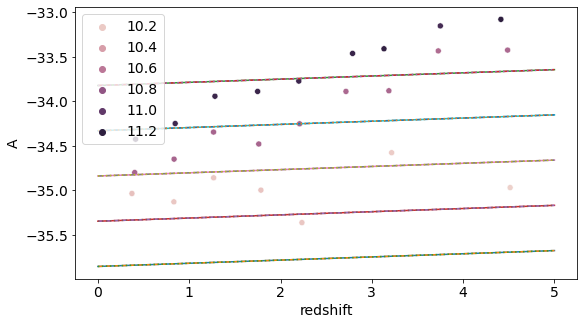

In [38]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],As_sf[idx_keep_sf], hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='A')
fig.set(xlabel='redshift');
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_list=[-1,0,1]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            A_mod_plot = model_A_or_Tdust(vA_just_sf, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, A_mod_plot, as_ls[j])
    except:
        A_mod_plot = model_A_or_Tdust(vA_just_sf, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, A_mod_plot)

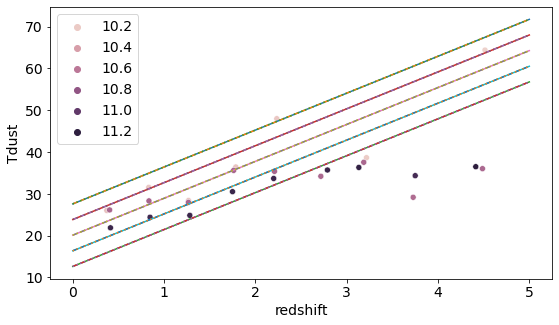

In [39]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],Ts_sf[idx_keep_sf], hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='Tdust')
fig.set(xlabel='redshift')
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[-1,0,1]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            T_mod_plot = model_A_or_Tdust(vT_just_sf, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, T_mod_plot, as_ls[j])
    except:
        T_mod_plot = model_A_or_Tdust(vT_just_sf, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, T_mod_plot)

In [40]:
combined_theta_model_just_sf= A_combined_model_just_sf, np.array(T_combined_model_just_sf / (1+Z_model_sf))

# Now fit SF and QT simultaneously

In [41]:
# Define Fit Parameters
fit_params_sfg = Parameters()
fit_params_sfg.add('A_offset_sf', value=cov_Adust_sf.params['offset'].value)
fit_params_sfg.add('T_offset_sf', value=cov_Tdust_sf.params['offset'].value)
fit_params_sfg.add('A_offset_qt', value=cov_Adust_qt.params['offset'].value)
fit_params_sfg.add('T_offset_qt', value=cov_Tdust_qt.params['offset'].value)

for key, val in simstack_object.config_dict['catalog']['classification'].items():

    if 'split_params' not in key:
        fit_params_sfg.add('A_slope_'+key+'_sf', value=cov_Adust_sf.params['slope_'+key].value)
        fit_params_sfg.add('T_slope_'+key+'_sf', value=cov_Tdust_sf.params['slope_'+key].value)
        fit_params_sfg.add('A_slope_'+key+'_qt', value=cov_Adust_qt.params['slope_'+key].value)
        fit_params_sfg.add('T_slope_'+key+'_qt', value=cov_Tdust_qt.params['slope_'+key].value)
    
cov_direct_fit = minimize(direct_convolved_fit_A_Tdust, fit_params_sfg,
                     args=(model_cube,),
                     kws={'y':map_dict},
                     nan_policy='propagate')

In [42]:
cov_direct_fit.params

name,value,standard error,relative error,initial value,min,max,vary
A_offset_sf,-48.0469129,0.03168568,(0.07%),-48.40169466462903,-inf,inf,True
T_offset_sf,115.943587,0.43868621,(0.38%),126.65272543858046,-inf,inf,True
A_offset_qt,-41.5757819,0.20051398,(0.48%),-42.46602910066544,-inf,inf,True
T_offset_qt,12.1652731,2.83581061,(23.31%),24.029875409015258,-inf,inf,True
A_slope_redshift_sf,0.09313441,8.5416e-04,(0.92%),0.2693153594428363,-inf,inf,True
T_slope_redshift_sf,7.02233756,0.02179962,(0.31%),4.415213679235314,-inf,inf,True
A_slope_redshift_qt,0.31300796,0.00483264,(1.54%),0.4676162441092372,-inf,inf,True
T_slope_redshift_qt,7.30592562,0.11470607,(1.57%),3.726474949061731,-inf,inf,True
A_slope_stellar_mass_sf,1.26155235,0.00298018,(0.24%),1.2672312642662973,-inf,inf,True
T_slope_stellar_mass_sf,-9.09048030,0.04002257,(0.44%),-9.584075307472585,-inf,inf,True


In [30]:
cov_direct_fit.params

name,value,standard error,relative error,initial value,min,max,vary
A_offset_sf,-48.3522249,0.03515992,(0.07%),-48.969796934719824,-inf,inf,True
T_offset_sf,114.027308,0.47788209,(0.42%),136.76534158263735,-inf,inf,True
A_offset_qt,-42.8715744,0.14582896,(0.34%),-44.29335652877317,-inf,inf,True
T_offset_qt,47.6217231,1.83584475,(3.86%),94.63916917299001,-inf,inf,True
A_slope_redshift_sf,0.08674435,9.0034e-04,(1.04%),0.22578576212548618,-inf,inf,True
T_slope_redshift_sf,7.06794521,0.02223860,(0.31%),5.415481630290377,-inf,inf,True
A_slope_redshift_qt,0.23768257,0.00317854,(1.34%),0.46090821710922236,-inf,inf,True
T_slope_redshift_qt,8.08522357,0.07932545,(0.98%),4.749580262572224,-inf,inf,True
A_slope_stellar_mass_sf,1.29301321,0.00330125,(0.26%),1.3276731027838795,-inf,inf,True
T_slope_stellar_mass_sf,-8.94023966,0.04368250,(0.49%),-10.702431963892048,-inf,inf,True


In [43]:
vT_sf = cov_direct_fit.params.copy()
vA_sf = cov_direct_fit.params.copy()
vT_qt = cov_direct_fit.params.copy()
vA_qt = cov_direct_fit.params.copy()

Alist = [i for i, j in vA_sf.items() if (('A_' in i) or ('_qt' in i))]
Tlist = [i for i, j in vT_sf.items() if (('T_' in i) or ('_qt' in i))]
Apop=[vA_sf.pop(i) for i in Tlist]
Tpop=[vT_sf.pop(i) for i in Alist]

Alist_qt = [i for i, j in vA_qt.items() if (('A_' in i) or ('_sf' in i))]
Tlist_qt = [i for i, j in vT_qt.items() if (('T_' in i) or ('_sf' in i))]
Apop=[vA_qt.pop(i) for i in Tlist_qt]
Tpop=[vT_qt.pop(i) for i in Alist_qt]


In [44]:
A_combined_model_sf = model_A_or_Tdust(vA_sf, model_cube_sf)
T_combined_model_sf = model_A_or_Tdust(vT_sf, model_cube_sf)

A_combined_model_qt = model_A_or_Tdust(vA_qt, model_cube_qt)
T_combined_model_qt = model_A_or_Tdust(vT_qt, model_cube_qt)

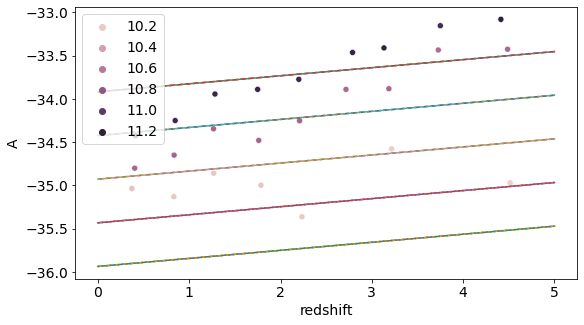

In [45]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],As_sf[idx_keep_sf], hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='A')
fig.set(xlabel='redshift');
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            A_mod_plot = model_A_or_Tdust(vA_sf, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, A_mod_plot, as_ls[j])
    except:
        A_mod_plot = model_A_or_Tdust(vA_sf, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, A_mod_plot)

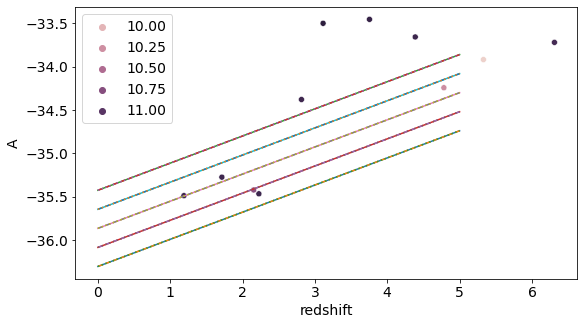

In [46]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_qt[idx_keep_qt],As_qt[idx_keep_qt], hue=Ms_qt[idx_keep_qt])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='A')
fig.set(xlabel='redshift');
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            A_mod_plot = model_A_or_Tdust(vA_qt, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, A_mod_plot, as_ls[j])
    except:
        A_mod_plot = model_A_or_Tdust(vA_qt, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, A_mod_plot)

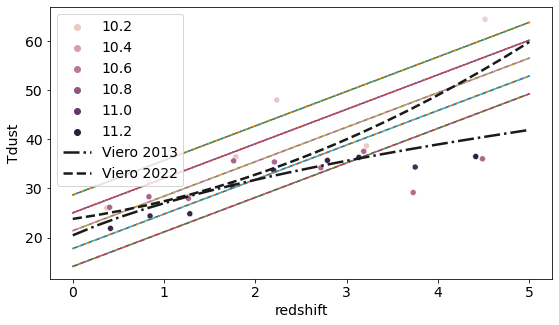

In [62]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],Ts_sf[idx_keep_sf], hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='Tdust')
fig.set(xlabel='redshift')
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[-1,0,1]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            T_mod_plot = model_A_or_Tdust(vT_sf, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, T_mod_plot, as_ls[j])
    except:
        T_mod_plot = model_A_or_Tdust(vT_sf, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, T_mod_plot)
        
plt.plot(zs_model, 27*((1+zs_model)/(1+1))**(0.4), '-.k', lw=2.5, label='Viero 2013');
Tv22 = 23.8 + 2.7 * zs_model + 0.9 * zs_model**2
plt.plot(zs_model, Tv22, '--k', lw=2.5, label='Viero 2022');
plt.legend();

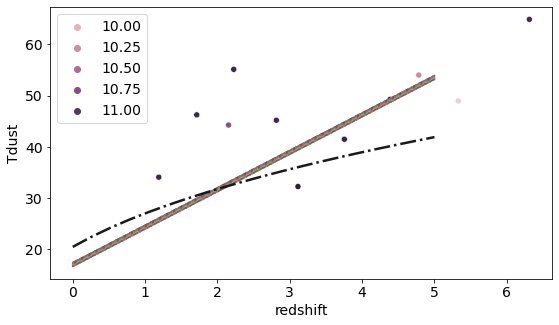

In [48]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_qt[idx_keep_qt],Ts_qt[idx_keep_qt], hue=Ms_qt[idx_keep_qt])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='Tdust')
fig.set(xlabel='redshift')
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[-1,0,1]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            T_mod_plot = model_A_or_Tdust(vT_qt, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, T_mod_plot, as_ls[j])
    except:
        T_mod_plot = model_A_or_Tdust(vT_qt, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, T_mod_plot)
plt.plot(zs_model, 27*((1+zs_model)/(1+1))**(0.4), '-.k', lw=2.5);

# Decompose LIR into AGN and non-AGN

In [50]:
L_sun = 3.839e26  # W
c = 299792458.0  # m/s
def fast_LIR(self, theta, zed, dzin=None):
    '''This calls graybody_fn instead of fast_sed'''
    wavelength_range = self.loggen(8, 1000, 1000)
    Lrf_array = np.zeros_like(zed)
    for iz, zin in enumerate(zed):
        theta_in = theta[0][iz], theta[1][iz]
        model_sed = self.graybody_fn(theta_in, wavelength_range)

        nu_in = c * 1.e6 / wavelength_range
        dnu = nu_in[:-1] - nu_in[1:]
        dnu = np.append(dnu[0], dnu)
        Lir = np.sum(model_sed * dnu, axis=1)
        conversion = 4.0 * np.pi * (
                    1.0E-13 * self.config_dict['cosmology_dict']['cosmology'].luminosity_distance(
                zin) * 3.08568025E22) ** 2.0 / L_sun  # 4 * pi * D_L^2    units are L_sun/(Jy x Hz)

        Lrf = (Lir * conversion.value)[0]  # Jy x Hz

        if dzin is not None:
            dLrf = np.zeros([2])
            for idz, dz in enumerate(dzin):
                conversion = 4.0 * np.pi * (
                        1.0E-13 * self.config_dict['cosmology_dict']['cosmology'].luminosity_distance(
                    dz) * 3.08568025E22) ** 2.0 / L_sun  # 4 * pi * D_L^2    units are L_sun/(Jy x Hz)
                dLrf[idz] = (Lir * conversion.value)[0]

            #return Lrf, dLrf
            Lrf_array[iz] = Lrf, dLrf
            
        Lrf_array[iz] = Lrf

    return Lrf_array

In [51]:
combined_theta_model_sf = A_combined_model_sf, T_combined_model_sf / (1+Z_model_sf)
combined_theta_model_qt = A_combined_model_qt, T_combined_model_qt / (1+Z_model_qt)

In [52]:
LIR_model_just_sf = fast_LIR(simstack_object, combined_theta_model_just_sf, Z_model_sf)

In [53]:
LIR_model_sf = fast_LIR(simstack_object, combined_theta_model_sf, Z_model_sf)

In [54]:
LIR_model_qt = fast_LIR(simstack_object, combined_theta_model_qt, Z_model_qt)

In [55]:
idx_sample_sf = np.random.choice(np.arange(len(Z_model_sf)), size=10000, replace=False)

In [56]:
idx_sample_qt = np.random.choice(np.arange(len(Z_model_qt)), size=10000, replace=False)

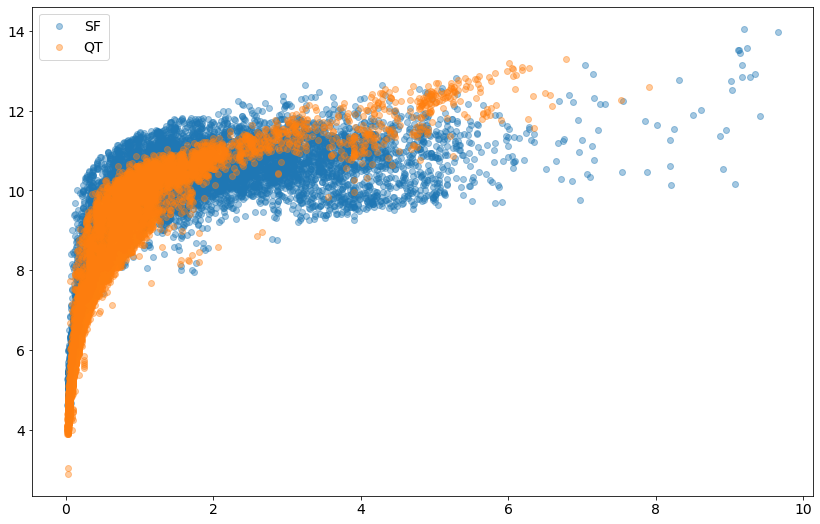

In [57]:
fig, axs = plt.subplots(1, 1, figsize=(14,9))
plt.scatter(Z_model_sf[idx_sample_sf], np.log10(LIR_model_sf[idx_sample_sf]), alpha=0.4, label='SF');
plt.scatter(Z_model_qt[idx_sample_qt], np.log10(LIR_model_qt[idx_sample_qt]), alpha=0.4, label='QT');
plt.legend();

In [58]:
zbins = np.array([0, .25, .5, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8])
binned_z = (zbins[:-1]+zbins[1:])/2

binned_lir_just_sf = np.zeros(len(zbins)-1)
binned_lir_sf = np.zeros(len(zbins)-1)
binned_lir_qt = np.zeros(len(zbins)-1)

#binned_uv_sfr_sf = np.zeros(len(zbins)-1)
#binned_uv_sfr_qt = np.zeros(len(zbins)-1)
#binned_uv_sfr = np.zeros(len(zbins)-1)

binned_vol = np.zeros(len(zbins)-1)
area_deg2 = 1.8 #1.6055

for iz in np.arange(len(zbins)-1):
    idx_z_sf = (Z_model_sf > zbins[iz]) & (Z_model_sf <= zbins[iz+1])
    idx_z_qt = (Z_model_qt > zbins[iz]) & (Z_model_qt <= zbins[iz+1])
    
    binned_lir_just_sf[iz] = np.sum(LIR_model_just_sf[idx_z_sf],axis=0)
    binned_lir_sf[iz] = np.sum(LIR_model_sf[idx_z_sf],axis=0)
    binned_lir_qt[iz] = np.sum(LIR_model_qt[idx_z_qt],axis=0)
    
    #binned_uv_sfr_sf[iz] = np.sum(uv_sfr_sf[idx_z_sf])
    #binned_uv_sfr_qt[iz] = np.sum(uv_sfr_qt[idx_z_qt])
    
    #idx_z_whole = (simstack_catalog_object.catalog_dict['tables']['full_table']['z_peak'] > zbins[iz]) & (simstack_catalog_object.catalog_dict['tables']['full_table']['z_peak'] <= zbins[iz+1])
    #binned_uv_sfr[iz] = np.sum(simstack_catalog_object.catalog_dict['tables']['full_table']['SFR_UV'][idx_z_whole])
    
    binned_vol[iz] = simstack_object.comoving_volume_given_area(area_deg2, zbins[iz], zbins[iz+1]).value

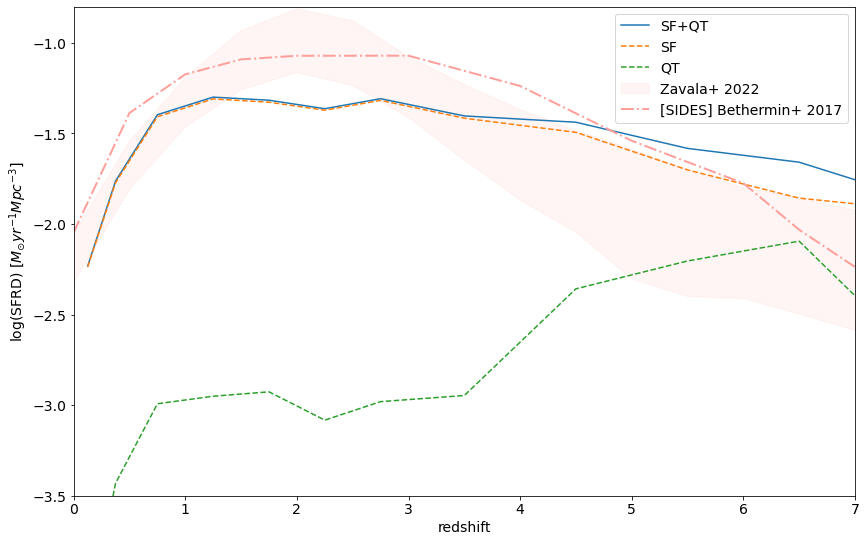

In [59]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt))/binned_vol), label='SF+QT')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf))/binned_vol), '--', label='SF')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_qt))/binned_vol), '--', label='QT')


xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='r', lw=2, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
plt.xlim([0,7])
#plt.ylim([7,9]);
plt.ylim([-3.5,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

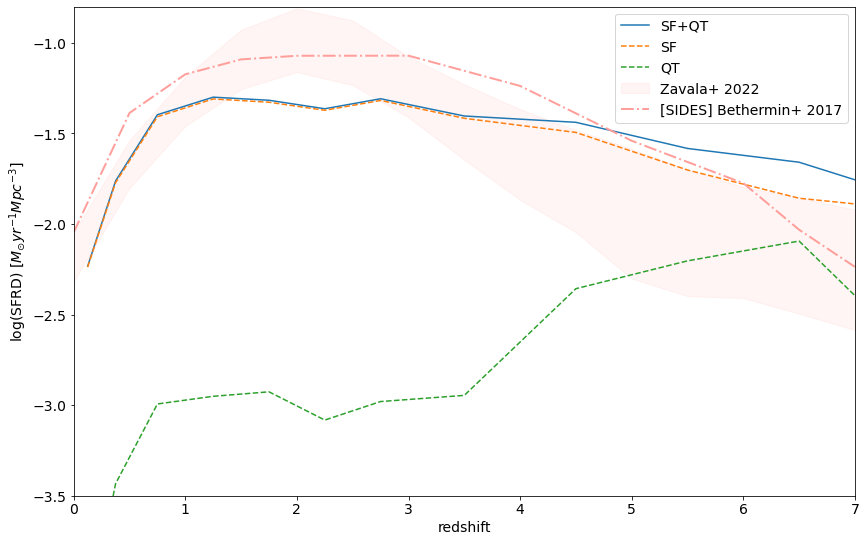

In [82]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt))/binned_vol), label='SF+QT')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf))/binned_vol), '--', label='SF')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_qt))/binned_vol), '--', label='QT')


xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='r', lw=2, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
plt.xlim([0,7])
#plt.ylim([7,9]);
plt.ylim([-3.5,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

## Now make maps from fits

In [61]:
simmap_dict = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key]
    map_lambda = map_object['wavelength']
    map_nu = c * 1.e6/map_lambda
    x, y = get_x_y_from_ra_dec(map_object, ra_model_sf, dec_model_sf)
    simmap_dict[map_key] = np.zeros_like(map_object['map'])
    simmap_dict[map_key][x,y] += get_map_flux_mJy(np.array([map_nu]),A_combined_model_sf,T_combined_model_sf/np.array(1+Z_model_sf))
    
    x, y = get_x_y_from_ra_dec(map_object, ra_model_qt, dec_model_qt)
    simmap_dict[map_key][x,y] += get_map_flux_mJy(np.array([map_nu]),A_combined_model_qt,T_combined_model_qt/np.array(1+Z_model_qt))

In [62]:
outmap_dict={}
def write_fits(self,
               mapin,
               map_name,
               path_map=r'C:\Users\viero\Desktop', 
               prefix='model_',
               overwrite=True, 
               show=False):
    
    if show:
        plt.imshow(model_250)

    map_object = self.maps_dict[map_name]
    #path_map = r'D:\maps\cutouts\layers'
    name_map = prefix+str(map_name)+'.fits'

    hd = map_object['header']
    fwhm = map_object['fwhm']
    pix = map_object['pixel_size']
    kern = gauss_kern(fwhm, np.floor(fwhm * 10) / pix, pix)
    tmap = smooth_psf(mapin, kern)
    
    ind_zero = abs(tmap) < 1e-10
    ind_non_zero = mapin != 0
    smap = tmap
    smap -= np.mean(smap[ind_non_zero])
    #smap[ind_zero]=0

    hdu = fits.PrimaryHDU(smap, header=hd)
    hdul = fits.HDUList([hdu])
    hdul.writeto(os.path.join(path_map, name_map),overwrite=overwrite)
    outmap_dict[name_map]=smap
    print('{0} written to {1}'.format(name_map,path_map))

In [63]:
for map_key in simmap_dict:
    write_fits(simstack_maps_object, simmap_dict[map_key], map_key, prefix='sfg_and_qt_convolved_mapfit_z_Trf_COSMOS'+prefix)

sfg_and_qt_convolved_mapfit_z_Trf_COSMOSSF_QT__COSMOS2020_mips_24.fits written to C:\Users\viero\Desktop
sfg_and_qt_convolved_mapfit_z_Trf_COSMOSSF_QT__COSMOS2020_pacs_green.fits written to C:\Users\viero\Desktop
sfg_and_qt_convolved_mapfit_z_Trf_COSMOSSF_QT__COSMOS2020_pacs_red.fits written to C:\Users\viero\Desktop
sfg_and_qt_convolved_mapfit_z_Trf_COSMOSSF_QT__COSMOS2020_spire_psw.fits written to C:\Users\viero\Desktop
sfg_and_qt_convolved_mapfit_z_Trf_COSMOSSF_QT__COSMOS2020_spire_pmw.fits written to C:\Users\viero\Desktop
sfg_and_qt_convolved_mapfit_z_Trf_COSMOSSF_QT__COSMOS2020_spire_plw.fits written to C:\Users\viero\Desktop
sfg_and_qt_convolved_mapfit_z_Trf_COSMOSSF_QT__COSMOS2020_scuba_850.fits written to C:\Users\viero\Desktop


# Compare map pixels

In [75]:
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key]
    if map_object['wavelength'] == 250.0:
        map_sky = map_object['map'] - np.mean(map_object['map'])
        map_lambda = map_object['wavelength']
        print(map_lambda)

        x_sf, y_sf = get_x_y_from_ra_dec(map_object, ra_model_sf, dec_model_sf)
        x_qt, y_qt = get_x_y_from_ra_dec(map_object, ra_model_qt, dec_model_qt)

        simmap_sky = simmap_dict[map_key] # - np.mean(simmap_dict[map_key])
        print(np.shape(map_sky))
        print(np.shape(simmap_sky))


250.0
(739, 879)
(739, 879)


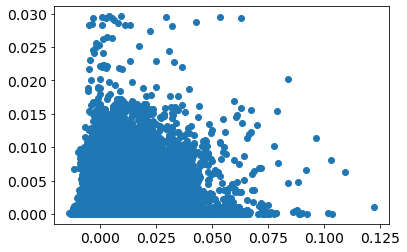

In [80]:
plt.plot(map_sky[simmap_sky != 0.],simmap_sky[simmap_sky != 0.],'o');

In [39]:
cov_direct_fit_qt.params

name,value,initial value,min,max,vary
A_offset,-44.2933565,-44.29335652877317,-inf,inf,True
T_offset,94.6391692,94.63916917299001,-inf,inf,True
A_slope_redshift,0.46090822,0.46090821710922236,-inf,inf,True
T_slope_redshift,4.74958026,4.749580262572224,-inf,inf,True
A_slope_stellar_mass,0.74158778,0.7415877755901965,-inf,inf,True
T_slope_stellar_mass,-5.46267217,-5.46267217262957,-inf,inf,True


In [40]:
vT_sf = cov_direct_fit_sf.params.copy()
vA_sf = cov_direct_fit_sf.params.copy()
Alist = [i for i, j in vA_sf.items() if 'A_' in i]
Tlist = [i for i, j in vT_sf.items() if 'T_' in i]
Apop=[vA_sf.pop(i) for i in Tlist]
Tpop=[vT_sf.pop(i) for i in Alist]
A_direct_model_sf = model_A_or_Tdust(vA_sf, model_cube_sf)
T_direct_model_sf = model_A_or_Tdust(vT_sf, model_cube_sf)
sed_direct_model_params_sf = {'A':vA_sf, 'Tdust':vT_sf}

In [41]:
vT_qt = cov_direct_fit_qt.params.copy()
vA_qt = cov_direct_fit_qt.params.copy()
Alist = [i for i, j in vA_qt.items() if 'A_' in i]
Tlist = [i for i, j in vT_qt.items() if 'T_' in i]
Apop=[vA_qt.pop(i) for i in Tlist]
Tpop=[vT_qt.pop(i) for i in Alist]
A_direct_model_qt = model_A_or_Tdust(vA_qt, model_cube_qt)
T_direct_model_qt = model_A_or_Tdust(vT_qt, model_cube_qt)
sed_direct_model_params_qt = {'A':vA_qt, 'Tdust':vT_qt}

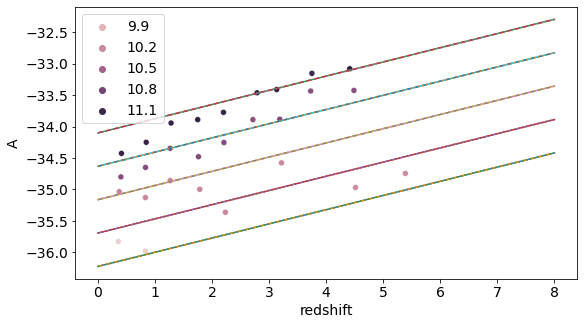

In [42]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],As_sf[idx_keep_sf], hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='A')
fig.set(xlabel='redshift');
zs_model=np.linspace(0,8,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_list=[-1,0,1]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            A_mod_plot = model_A_or_Tdust(vA_sf, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, A_mod_plot, as_ls[j])
    except:
        A_mod_plot = model_A_or_Tdust(vA_sf, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, A_mod_plot)

In [43]:
vA_sf

name,value,initial value,min,max,vary
A_offset,-48.9697969,-48.969796934719824,-inf,inf,True
A_slope_redshift,0.22578576,0.22578576212548618,-inf,inf,True
A_slope_stellar_mass,1.32767310,1.3276731027838795,-inf,inf,True


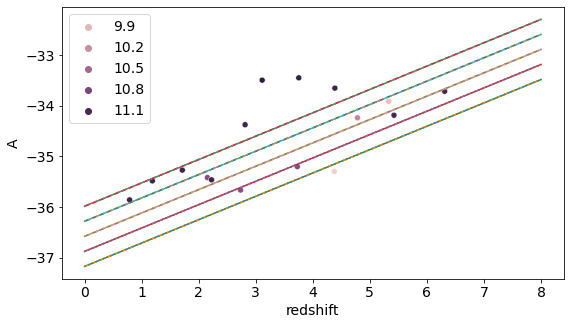

In [44]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_qt[idx_keep_qt],As_qt[idx_keep_qt], hue=Ms_qt[idx_keep_qt])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='A')
fig.set(xlabel='redshift');
zs_model=np.linspace(0,8,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_list=[-1,0,1]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            A_mod_plot = model_A_or_Tdust(vA_qt, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, A_mod_plot, as_ls[j])
    except:
        A_mod_plot = model_A_or_Tdust(vA_qt, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, A_mod_plot)

In [45]:
vA_qt

name,value,initial value,min,max,vary
A_offset,-44.2933565,-44.29335652877317,-inf,inf,True
A_slope_redshift,0.46090822,0.46090821710922236,-inf,inf,True
A_slope_stellar_mass,0.74158778,0.7415877755901965,-inf,inf,True


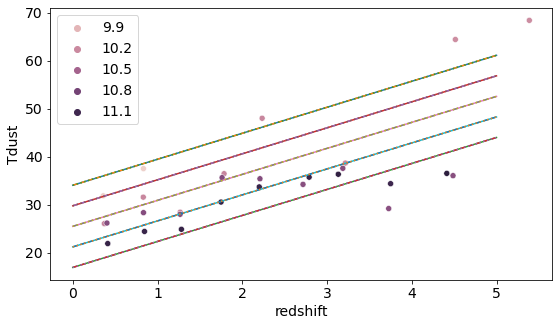

In [46]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],Ts_sf[idx_keep_sf], hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='Tdust')
fig.set(xlabel='redshift')
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[-1,0,1]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            T_mod_plot = model_A_or_Tdust(vT_sf, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, T_mod_plot, as_ls[j])
    except:
        T_mod_plot = model_A_or_Tdust(vT_sf, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, T_mod_plot)

In [47]:
vT_sf

name,value,initial value,min,max,vary
T_offset,136.765342,136.76534158263735,-inf,inf,True
T_slope_redshift,5.41548163,5.415481630290377,-inf,inf,True
T_slope_stellar_mass,-10.7024320,-10.702431963892048,-inf,inf,True


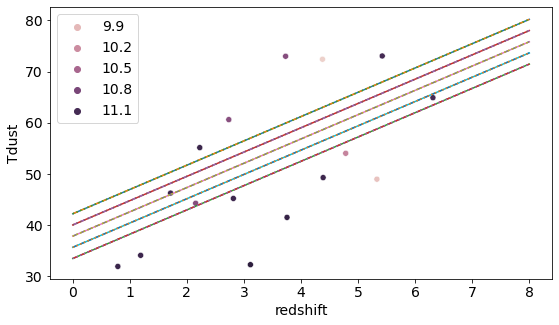

In [48]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_qt[idx_keep_qt],Ts_qt[idx_keep_qt], hue=Ms_qt[idx_keep_qt])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='Tdust')
fig.set(xlabel='redshift')
zs_model=np.linspace(0,8,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[-1,0,1]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            T_mod_plot = model_A_or_Tdust(vT_qt, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, T_mod_plot, as_ls[j])
    except:
        T_mod_plot = model_A_or_Tdust(vT_qt, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, T_mod_plot)

In [49]:
vT_qt

name,value,initial value,min,max,vary
T_offset,94.6391692,94.63916917299001,-inf,inf,True
T_slope_redshift,4.74958026,4.749580262572224,-inf,inf,True
T_slope_stellar_mass,-5.46267217,-5.46267217262957,-inf,inf,True


In [55]:
L_sun = 3.839e26  # W
c = 299792458.0  # m/s
def fast_LIR(self, theta, zed, dzin=None):
    '''This calls graybody_fn instead of fast_sed'''
    wavelength_range = self.loggen(8, 1000, 1000)
    Lrf_array = np.zeros_like(zed)
    for iz, zin in enumerate(zed):
        theta_in = theta[0][iz], theta[1][iz]
        model_sed = self.graybody_fn(theta_in, wavelength_range)

        nu_in = c * 1.e6 / wavelength_range
        dnu = nu_in[:-1] - nu_in[1:]
        dnu = np.append(dnu[0], dnu)
        Lir = np.sum(model_sed * dnu, axis=1)
        conversion = 4.0 * np.pi * (
                    1.0E-13 * self.config_dict['cosmology_dict']['cosmology'].luminosity_distance(
                zin) * 3.08568025E22) ** 2.0 / L_sun  # 4 * pi * D_L^2    units are L_sun/(Jy x Hz)

        Lrf = (Lir * conversion.value)[0]  # Jy x Hz

        if dzin is not None:
            dLrf = np.zeros([2])
            for idz, dz in enumerate(dzin):
                conversion = 4.0 * np.pi * (
                        1.0E-13 * self.config_dict['cosmology_dict']['cosmology'].luminosity_distance(
                    dz) * 3.08568025E22) ** 2.0 / L_sun  # 4 * pi * D_L^2    units are L_sun/(Jy x Hz)
                dLrf[idz] = (Lir * conversion.value)[0]

            #return Lrf, dLrf
            Lrf_array[iz] = Lrf, dLrf
            
        Lrf_array[iz] = Lrf

    return Lrf_array

In [50]:
theta_model_sf = A_model_sf, T_model_sf / (1+Z_model_sf)
theta_model_qt = A_model_qt, T_model_qt / (1+Z_model_qt)

In [78]:
theta_model_sf

(array([-37.23103235, -41.62814432, -38.67621388, ..., -38.66890574,
        -42.09015475, -39.23018644]),
 array([20.69605483, 70.32263031, 45.35917677, ..., 32.83084304,
        75.74525203, 46.26129631]))

In [56]:
LIR_model_sf = fast_LIR(simstack_object, theta_model_sf, Z_model_sf)

In [57]:
LIR_model_qt = fast_LIR(simstack_object, theta_model_qt, Z_model_qt)

In [58]:
LIR_model_sf2 = fast_LIR(simstack_object, combined_theta_model_sf, Z_model_sf)

In [59]:
LIR_model_qt2 = fast_LIR(simstack_object, combined_theta_model_qt, Z_model_qt)

In [60]:
idx_sample_sf = np.random.choice(np.arange(len(Z_model_sf)), size=100000, replace=False)

In [61]:
idx_sample_qt = np.random.choice(np.arange(len(Z_model_qt)), size=50000, replace=False)

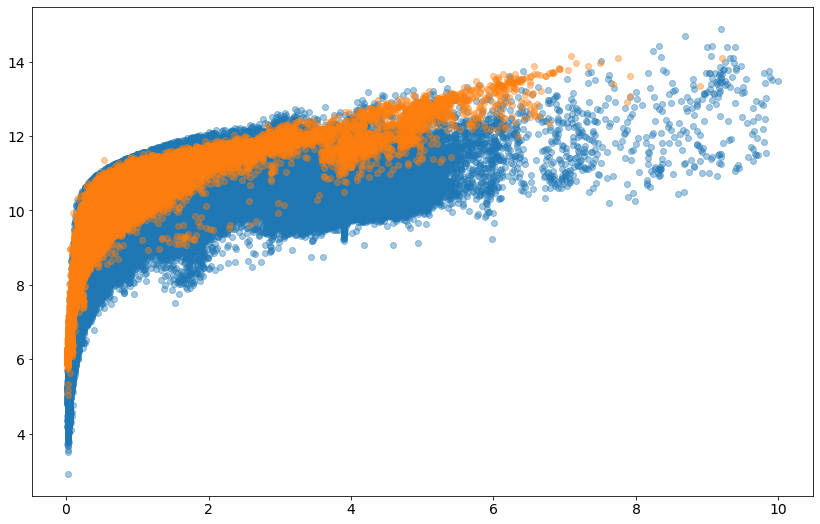

In [63]:
fig, axs = plt.subplots(1, 1, figsize=(14,9))
plt.scatter(Z_model_sf[idx_sample_sf], np.log10(LIR_model_sf[idx_sample_sf]), alpha=0.4);
plt.scatter(Z_model_qt[idx_sample_qt], np.log10(LIR_model_qt[idx_sample_qt]), alpha=0.4);

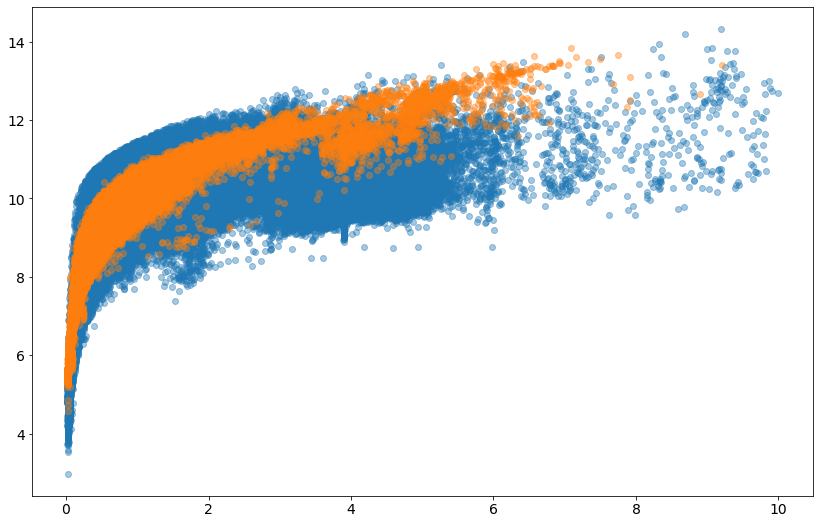

In [62]:
fig, axs = plt.subplots(1, 1, figsize=(14,9))
plt.scatter(Z_model_sf[idx_sample_sf], np.log10(LIR_model_sf2[idx_sample_sf]), alpha=0.4);
plt.scatter(Z_model_qt[idx_sample_qt], np.log10(LIR_model_qt2[idx_sample_qt]), alpha=0.4);

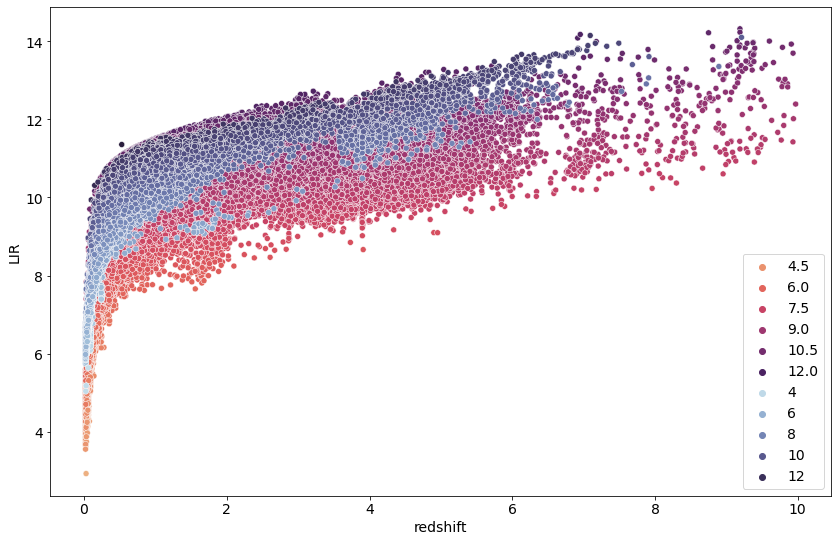

In [102]:
fig, axs = plt.subplots(1, 1, figsize=(14,9))
sns.scatterplot(Z_model_sf[idx_sample_sf], np.log10(LIR_model_sf[idx_sample_sf]), markers='o', hue=M_model_sf[idx_sample_sf], palette='flare', alpha=1);
sns.scatterplot(Z_model_qt[idx_sample_qt], np.log10(LIR_model_qt[idx_sample_qt]), markers='o', hue=M_model_qt[idx_sample_qt], palette='ch:s=.25,rot=-.25', alpha=1);
plt.xlabel('redshift')
plt.ylabel('LIR');

In [66]:
zbins = np.array([0, .25, .5, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 8])
binned_z = (zbins[:-1]+zbins[1:])/2

binned_lir_sf = np.zeros(len(zbins)-1)
binned_lir_qt = np.zeros(len(zbins)-1)
binned_vol = np.zeros(len(zbins)-1)

area_deg2 = 1.6055

for iz in np.arange(len(zbins)-1):
    idx_z_sf = (Z_model_sf > zbins[iz]) & (Z_model_sf <= zbins[iz+1])
    idx_z_qt = (Z_model_qt > zbins[iz]) & (Z_model_qt <= zbins[iz+1])
    binned_lir_sf[iz] = np.sum(LIR_model_sf2[idx_z_sf],axis=0)
    binned_lir_qt[iz] = np.sum(LIR_model_qt2[idx_z_qt],axis=0)
    binned_vol[iz] = simstack_object.comoving_volume_given_area(area_deg2, zbins[iz], zbins[iz+1]).value

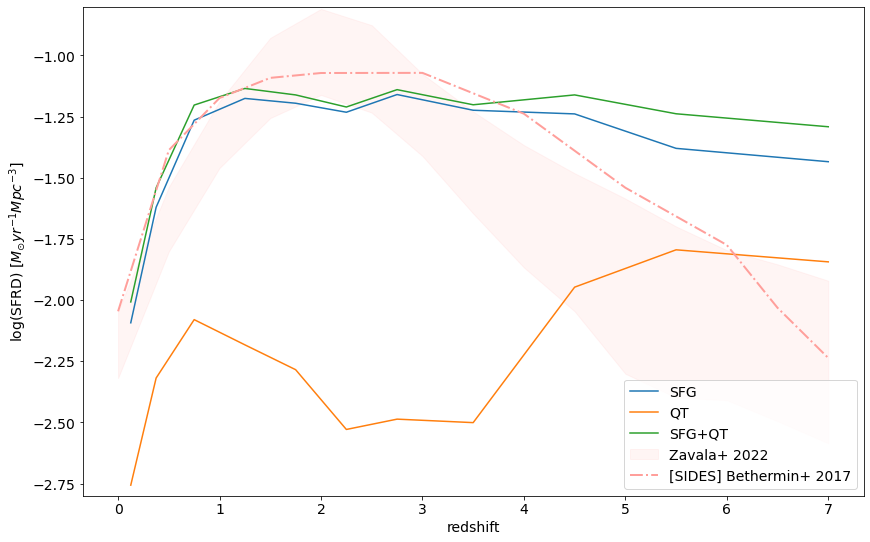

In [77]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))
plt.plot(binned_z, np.log10(conv_lir_to_sfr*binned_lir_sf /binned_vol), label='SFG')
plt.plot(binned_z, np.log10(conv_lir_to_sfr*binned_lir_qt /binned_vol), label='QT')
plt.plot(binned_z, np.log10(conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt) /binned_vol), label='SFG+QT')

xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='r', lw=2, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
#plt.xlim([0,4.2])
#plt.ylim([7,9]);
plt.ylim([-2.8,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

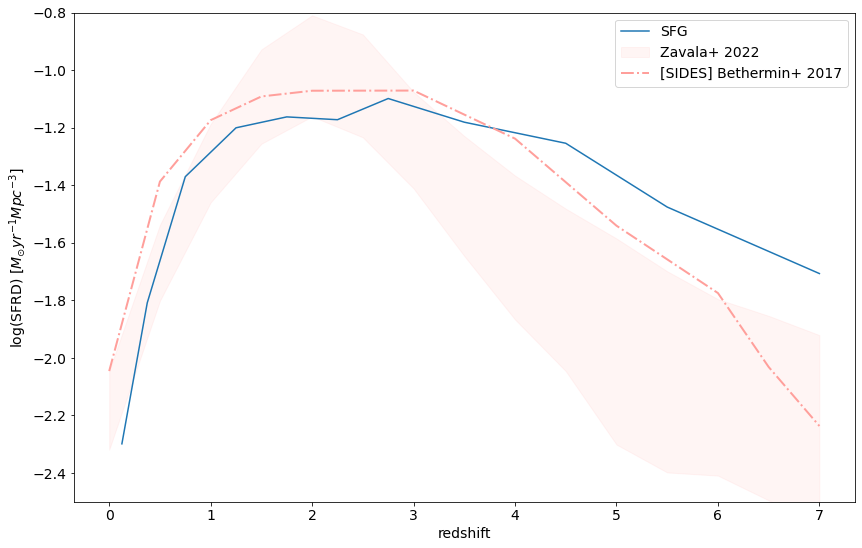

In [109]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))
plt.plot(binned_z, np.log10(conv_lir_to_sfr*binned_lir_sf /binned_vol), label='SFG')

xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='r', lw=2, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
#plt.xlim([0,4.2])
#plt.ylim([7,9]);
plt.ylim([-2.5,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

In [69]:
outmap_dict={}
def write_fits(self,
               mapin,
               map_name,
               path_map=r'C:\Users\viero\Desktop', 
               prefix='model_',
               overwrite=True, 
               show=False):
    
    if show:
        plt.imshow(model_250)

    map_object = self.maps_dict[map_name]
    #path_map = r'D:\maps\cutouts\layers'
    name_map = prefix+str(map_name)+'.fits'

    hd = map_object['header']
    fwhm = map_object['fwhm']
    pix = map_object['pixel_size']
    kern = gauss_kern(fwhm, np.floor(fwhm * 10) / pix, pix)
    tmap = smooth_psf(mapin, kern)
    
    ind_zero = abs(tmap) < 1e-10
    ind_non_zero = mapin != 0
    smap = tmap
    smap -= np.mean(smap[ind_non_zero])
    #smap[ind_zero]=0

    hdu = fits.PrimaryHDU(smap, header=hd)
    hdul = fits.HDUList([hdu])
    hdul.writeto(os.path.join(path_map, name_map),overwrite=overwrite)
    outmap_dict[name_map]=smap
    print('{0} written to {1}'.format(name_map,path_map))

In [68]:
simmap_dict = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key]
    map_lambda = map_object['wavelength']
    map_nu = c * 1.e6/map_lambda
    simmap_dict[map_key] = np.zeros_like(map_object['map'])

    x_sf, y_sf = get_x_y_from_ra_dec(map_object, ra_model_sf, dec_model_sf)
    simmap_dict[map_key][x_sf,y_sf] = get_map_flux_mJy(np.array([map_nu]),A_combined_model_sf,T_combined_model_sf / (1+Z_model_sf))
    
    x_qt, y_qt = get_x_y_from_ra_dec(map_object, ra_model_qt, dec_model_qt)
    simmap_dict[map_key][x_qt,y_qt] = get_map_flux_mJy(np.array([map_nu]),A_combined_model_qt,T_combined_model_qt / (1+Z_model_qt))

In [70]:
prefix

'SF_QT__COSMOS2020_'

In [71]:
for map_key in simmap_dict:
    write_fits(simstack_maps_object, simmap_dict[map_key], map_key, prefix='sfg_and_qt_convolved_mapfit_z_Trf_'+prefix)

sfg_and_qt_convolved_mapfit_z_Trf_SF_QT__COSMOS2020_mips_24.fits written to C:\Users\viero\Desktop
sfg_and_qt_convolved_mapfit_z_Trf_SF_QT__COSMOS2020_pacs_green.fits written to C:\Users\viero\Desktop
sfg_and_qt_convolved_mapfit_z_Trf_SF_QT__COSMOS2020_pacs_red.fits written to C:\Users\viero\Desktop
sfg_and_qt_convolved_mapfit_z_Trf_SF_QT__COSMOS2020_spire_psw.fits written to C:\Users\viero\Desktop
sfg_and_qt_convolved_mapfit_z_Trf_SF_QT__COSMOS2020_spire_pmw.fits written to C:\Users\viero\Desktop
sfg_and_qt_convolved_mapfit_z_Trf_SF_QT__COSMOS2020_spire_plw.fits written to C:\Users\viero\Desktop
sfg_and_qt_convolved_mapfit_z_Trf_SF_QT__COSMOS2020_scuba_850.fits written to C:\Users\viero\Desktop
